# Observational study

The goal of the present project is to define a valid metric to evaluate the impact of actors on movies. Specifically, distilling actors careers to a single number, the *star score*. Identifying the latter implies the need to identify truly successful actors, namely actors that had the highest positive impact on movies, in terms of revenues and ratings. Given the presence of multiple confounders, such as the affinity of actors with  particulare genres, different genders or the preference of directors for specific actors, an observational study is carried out to limit the influence of unobserved covariates.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

In [241]:
#importing our clean data
data = pd.read_csv('../data/data.csv', index_col = 0)
data_profit = pd.read_csv('../data/profit_data.csv', index_col = 0)
actors = pd.read_csv('../data/timeScores.csv', index_col = 0)
ss = pd.read_csv('obs.csv', index_col = 0)

In [242]:
actors['appearances'] = ss['appearances']
actors['gender'] = ss['gender']

In [243]:
actors.head(1)

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender
0,Dustin_Farnum,[6117500.],[1914.],[2.86153647],[6117500.],[2.86153647],[16.67802278],[2.69731427],"['Black-and-white', 'Drama', 'Indie', 'Silent ...",[1 1 1 1 1],Black-and-white,Drama,1.0,M


The treatment and control group of the observational study will be identified by the number of times actors starred in movies. The assumption is that successful actors keep acting, while the career of less-successfull ones ends early. This hypothesis is supported by the rich-get-richer mechanism, for which successful actors keep starring with other successful actors, making them even more successful and naturally generating a power law in the appearances distribution.

Just as normal distributions arise from many independent random decisions averaging out, we power laws arise from the feedback introduced by correlated decisions across a population.

Source:
Networks, Crowds, and Markets: Reasoning about a Highly Connected World.
By David Easley and Jon Kleinberg. Cambridge University Press, 2010.
http://www.cs.cornell.edu/home/kleinber/networks-book/

Thedistribution of the number of appearances is shown below. The distribution is a power law because it is represented by a straight line in bi-logarithmic axes (it is linear in the log domain).

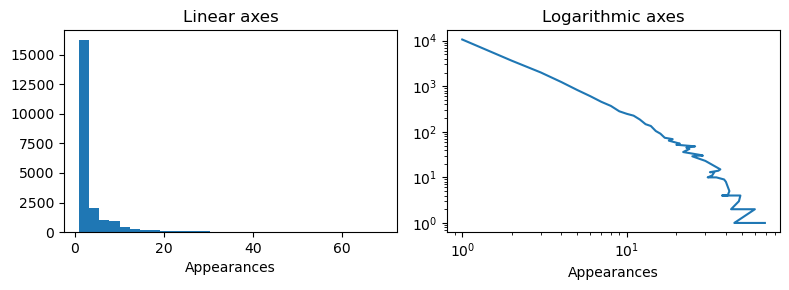

In [244]:
#2 subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))

#group by number of appearances and sort
act = actors.groupby('appearances')['appearances'].count().sort_values(ascending=False)

sbplt = ax[0]
sbplt.hist(actors.appearances, bins=30)
sbplt.set_title('Linear axes')
sbplt.set_xlabel('Appearances')

sbplt = ax[1]
sbplt.loglog(act.index,act.values)
sbplt.set_title('Logarithmic axes')
sbplt.set_xlabel('Appearances')
    
fig.tight_layout()
plt.show()

Supported by the previous assumption, the treatment group will be the group with the higher number of appearances. The splitting of the dataset will be carried out based on the median of the distribution, more representative than the mean when considering skewed distributions.

In [245]:
#median
print('The median of the distribution is ' + str(np.median(actors.appearances)))
print('The mean of the distribution is ' + str(np.mean(actors.appearances)))

The median of the distribution is 2.0
The mean of the distribution is 3.588943623426382


In [246]:
actors['treatment'] = (actors['appearances'] > 2).astype(int)

In [247]:
actors.head(1)

,actor,revenues,movie_years,ratings,cumulative_revenue,cumulative_ratings,star_score,epfl_score,genres,genre_count,main_genre,2nd_genre,appearances,gender,treatment
0,Dustin_Farnum,[6117500.],[1914.],[2.86153647],[6117500.],[2.86153647],[16.67802278],[2.69731427],"['Black-and-white', 'Drama', 'Indie', 'Silent ...",[1 1 1 1 1],Black-and-white,Drama,1.0,M,0


To limit the effect of confounders, the individuals of the groups will be matched on propensity score, namely the probability of being in the treatment group based on observed covariates. To extract the propensity scores, a logistic regression is trained and applied on the same dataset, this will output the needed probabilities.

In is worth mentioning that the revenues and ratings are characteristics that define the success of the movie and that will set the basis for the definition of the *star score*. Therefore, they are not included in the matching features, otherwise they would bias the process of identification of successful actors.

In [252]:
X = actors[{'main_genre','2nd_genre','gender'}]

In [253]:
X = pd.get_dummies(X,columns=['main_genre','2nd_genre','gender'])
y = actors['treatment']

In [254]:
X.head(3)

,main_genre_Absurdism,main_genre_Action,main_genre_Action Comedy,main_genre_Action Thrillers,main_genre_Action/Adventure,main_genre_Addiction Drama,main_genre_Adult,main_genre_Adventure,main_genre_Adventure Comedy,main_genre_Airplanes and airports,...,2nd_genre_Suspense,2nd_genre_Teen,2nd_genre_Thriller,2nd_genre_Time travel,2nd_genre_War film,2nd_genre_Western,2nd_genre_Workplace Comedy,2nd_genre_World cinema,gender_F,gender_M
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [262]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs', max_iter=100000)
logistic.fit(X,y)

LogisticRegression(max_iter=100000)

In [263]:
actors['propensity_score'] = [i[0] for i in list(logistic.predict_proba(X))]

To further balance the two sub-groups of actors, the process will only match actors of the same gender. Indeed, the gender is a possible confounder for linking the actors to movie success.

In [264]:
#function to compute similarity (difference between propensity scores to be minimized in the matching)
def get_similarity(prop1,prop2):
    return 1-abs(prop1-prop2)

In [265]:
import networkx as nx

In [266]:
ran = actors.sample(frac=.05)

In [268]:
# Create an empty undirected graph
G = nx.Graph()

#define treatment and control groups
treat = ran[ran['appearances'] > 2]
contr = ran[ran['appearances'] <= 2]

# Loop through all the pairs of instances
for i, j in contr.iterrows():
    for k, l in treat.iterrows():
        if j['gender'] == l['gender']:
            # Calculate the similarity 
            similarity = get_similarity(j['propensity_score'],
                                    l['propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(i, k, similarity)])

In [270]:
# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)] #create list with all indexes of people paired

balanced_df = ran.loc[matched] #extract only rows with paired subjects

In [286]:
ss.head(3)

,actor,rev_sum,grade_sum,appearances,score,score_epfl,gender,cluster
0,Dustin_Farnum,6.117500e+06,2.861536,1.0,16.678023,3.278702,M,2
1,Elmer_Clifton,1.250000e+09,4.791714,1.0,22.513298,5.319083,M,0
2,Robert_Harron,1.250000e+09,4.791714,1.0,22.513298,5.319083,M,0


In [290]:
balanced_ss = ss.loc[balanced_df.index]

In [292]:
balanced_df['revenues'] = balanced_ss['rev_sum']
balanced_df['ratings'] = balanced_ss['grade_sum']

To assess the different influence of the success-related features on the balanced dataset (revenues and ratings), a linear regression is implemented.

In [316]:
#log and standardization
X1 = balanced_df[{'treatment','revenues','ratings'}]
X1['revenues'] = X1['revenues'].apply('log')
X1['ratings'] = X1['ratings'].apply('log')
X1['revenues'] = (X1['revenues'] - X1['revenues'].mean())/X1['revenues'].std()
X1['ratings'] = (X1['ratings'] - X1['ratings'].mean())/X1['ratings'].std()

In [335]:
#linear regression
import statsmodels.formula.api as smf #for linear and logistic regression

mod = smf.ols(formula='treatment ~ revenues + ratings',
              data=X1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              treatment   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     45.07
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           3.17e-19
Time:                        13:22:52   Log-Likelihood:                -511.74
No. Observations:                 764   AIC:                             1029.
Df Residuals:                     761   BIC:                             1043.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5000      0.017     29.174      0.0

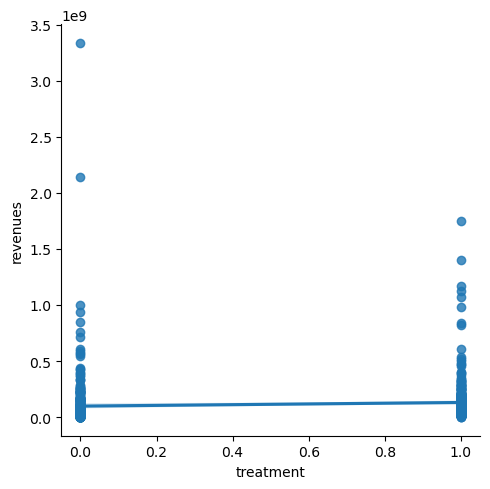

In [349]:
sns.lmplot(x='treatment',y='revenues', data=balanced_df)